# Import and misc

In [ ]:
%pip install torchaudio==0.9.1

     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 831.4 MB 6.0 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [ ]:
%pip install thop

In [ ]:
%pip install wandb

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 97 kB 6.2 MB/s 
     |████████████████████████████████| 180 kB 44.3 MB/s 
     |████████████████████████████████| 140 kB 50.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=6843a3e4f6e2bd1c8d3d9624e2305cfda47c37ef4854bbaeba719be2131bd815
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=76e0d53e60273c551efb6c872d31b4a29b899ae881e53b22e452355416a327ee
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [ ]:

@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-21 16:33:52--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.217.128, 2607:f8b0:400c:c13::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.217.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   166MB/s    in 9.4s    

2021-11-21 16:34:01 (150 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [ ]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [ ]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [ ]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
dataset.csv.sample(5)

,path,keyword,label
50866,speech_commands/yes/1b63157b_nohash_1.wav,yes,0
1003,speech_commands/house/51995cea_nohash_0.wav,house,0
38126,speech_commands/stop/a1cff772_nohash_2.wav,stop,0
144,speech_commands/house/4fd4d073_nohash_1.wav,house,0
31651,speech_commands/sheila/7ff085e1_nohash_0.wav,sheila,1


### Augmentations

In [ ]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [ ]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [ ]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [ ]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [ ]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [ ]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          #num_workers=2, 
                          pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        #num_workers=2, 
                        pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [ ]:

class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [ ]:
#!g1.1
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [ ]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [ ]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [ ]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [ ]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [ ]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [ ]:
#!g1.1
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
    
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)
print(config)
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)
TaskConfig(keyword='sheila', batch_size=128, learning_rate=0.0003, weight_decay=1e-05, num_epochs=20, n_mels=40, cnn_out_channels=8, kernel_size=(5, 20), stride=(2, 8), hidden_size=64, gru_num_layers=2, bidirectional=False, num_classes=2, sample_rate=16000, device=device(type='cpu'))


In [ ]:
#!g1.1


In [ ]:
sum([p.numel() for p in model.parameters()])

70443

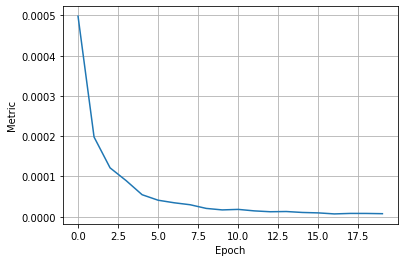

END OF EPOCH 19


In [ ]:
#!g1.1
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
#!g1.1
torch.save(model.state_dict(), 'base_model.pt')

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.000497902332430891,
              0.00019790774798032084,
              0.00012132620987178575,
              8.969820769184061e-05,
              5.461499546242601e-05,
              4.0961246596819505e-05,
              3.462371106566824e-05,
              2.971838695398618e-05,
              2.064174708310004e-05,
              1.6912029844898962e-05,
              1.818311747967789e-05,
              1.4489205526963542e-05,
              1.2352823492921966e-05,
              1.2913772965547409e-05,
              1.056255921858545e-05,
              9.500335749145783e-06,
              6.952192932006807e-06,
              8.17554018613676e-06,
              8.109897162744421e-06,
              7.513142404632249e-06]})

## Итоговый эксперимент, показавший наилучшее ужимание

In [ ]:

tconfig = TaskConfig()
teacher = CRNN(tconfig)
teacher.load_state_dict(torch.load('base_model.pt', map_location='cpu'))
teacher.eval()

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
@dataclasses.dataclass
class StudentConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 50
    n_mels: int = 40
    cnn_out_channels: int = 4 #Уменьшим к-во каналов в 2 раза
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 16 #Уменьшим размер скрытого слоя в 4 раза
    gru_num_layers: int = 1 #Уменьшим к-во gru в 2 раза
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    alpha: float = 0.2
    T: float = 5
    

In [ ]:

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
sconfig = StudentConfig()
student = CRNN(sconfig)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
print("number of parameters for student:", sum([p.numel() for p in student.parameters()]))
  
print("number of parameters for teacher:", sum([p.numel() for p in teacher.parameters()]))

number of parameters for student: 5047
number of parameters for teacher: 70443


In [ ]:
sopt = torch.optim.Adam(
    student.parameters(),
    lr=sconfig.learning_rate,
    weight_decay=sconfig.weight_decay
)

In [ ]:
from thop import profile
for x, y in train_loader:
    print(profile(teacher, (melspec_train(x.to(config.device)), ) )) 
    break

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
(119527424.0, 70443.0)


In [ ]:
from thop import profile
for x, y in train_loader:
    print(profile(student, (melspec_train(x.to(config.device)), ) )) 
    break

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
(16866304.0, 5047.0)


In [1]:
119527424.0 / 16866304.0

7.086758545322081

Таким образом, ужимание по времени примерно в 7 раз

In [4]:
VERY_IMPORTANT_CONSTANT = 5e-5 * 1.1

In [ ]:
#!g1.1

#Это функция потерь для dkd (вроде)
#https://towardsdatascience.com/distilling-knowledge-in-neural-network-d8991faa2cdc
#Только там почему-то считается CE для дейблов студента, а не логитов
def dkd_loss(
    logits_student, #выходы модели студента
    logits_teacher, #выходы учителя
    y_true, #Это реальные лейблы (hard targets)
    alpha=0.5, #Это параметр альфа,
    T=1.5 #Это температура
):
    '''
    probs_student = F.log_softmax(logits_student / T, dim=-1)
    probs_teacher = F.log_softmax(logits_teacher / T, dim=-1)
    
    loss1 = F.cross_entropy(probs_student, probs_teacher) * alpha
    
    loss2 = F.cross_entropy(logits_student, labels) * (1 - alpha)
    
    return loss1 + loss2'''
    
    probs_student = F.log_softmax(logits_student / T, dim=-1)
    probs_teacher = F.log_softmax(logits_teacher / T, dim=-1)
    
    loss1 = nn.KLDivLoss()(probs_student,probs_teacher) * alpha * (T ** 2)
    
    loss2 = F.cross_entropy(logits_student, y_true) * (1 - alpha)
    
    return loss1 + loss2
    


#код почти повторяет код с сменианра
#Я добавила параметр config (мне понравилось, как в прошлом дз с ним работали) оттуда нам надо будет выцыганить config.alpha, config.T
def dkd_train_epoch(student, teacher, opt, loader, log_melspec, device, config):
    student.train()
    teacher.eval()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        
        # run model # with autocast():
        logits_student = student(batch)
        #Получили предсказания для учителя без градиента (так как обучаем не его)
        with torch.no_grad():
            logits_teacher = teacher(batch)
        
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits_student, dim=-1)
        loss = dkd_loss(logits_student,
                        logits_teacher,
                        labels,
                        config.alpha,
                        config.T)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc


#код почти повторяет код с сменианра
@torch.no_grad()
def dkd_validation(student, teacher, loader, log_melspec, device, config):
    
    student.eval()
    teacher.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        #TODO: заменить device на config.device
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        logits_student = student(batch)
        logits_teacher = teacher(batch)
        
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits_student, dim=-1)
        loss = dkd_loss(logits_student,
                        logits_teacher,
                        labels,
                        config.alpha,
                        config.T)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr


def dkd_train(student, teacher, #Две модельки: ученик и учитель
              train_loader, val_loader, #Два загрузчика: для трейна и валида
              melspec_train, melspec_val, #melspec для трейна и валида
              opt,   config, 
              #Эта штука для логгирования в wandb, вроде ее можно создавать и внутри функции, но я хз
              wandb_run=None
             ):
    history = []
    for n in range(config.num_epochs):

        dkd_train_epoch(student, teacher, opt, train_loader, melspec_train, config.device, config)

        au_fa_fr = dkd_validation(student, teacher, val_loader, melspec_val, config.device, config)
        history.append(au_fa_fr)
        if wandb_run is not None:
            #Это из инструкции в wandb
            wandb_run.log({'val_metric':au_fa_fr})
        
        if au_fa_fr < VERY_IMPORTANT_CONSTANT:
          print('END OF EPOCH', n, '/', config.num_epochs, 'val metric', au_fa_fr)
          print('Beat the baseline for student\nSaving model')
          torch.save(student.state_dict(), 'student_model.pt')
          break

      
        

        print('END OF EPOCH', n, '/', config.num_epochs, 'val metric', au_fa_fr)
    return history

In [ ]:
student = student.to(sconfig.device)
teacher = teacher.to(sconfig.device)
history = dkd_train(student, teacher, #Две модельки: ученик и учитель
              train_loader, val_loader, #Два загрузчика: для трейна и валида
              melspec_train, melspec_val, #melspec для трейна и валида
              sopt,   sconfig
             )

  0%|          | 0/405 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 405/405 [02:08<00:00,  3.14it/s]
102it [00:16,  6.27it/s]


END OF EPOCH 0 / 50 val metric 0.002236457806976988


100%|██████████| 405/405 [01:56<00:00,  3.48it/s]
102it [00:15,  6.38it/s]


END OF EPOCH 1 / 50 val metric 0.0008466458130716443


100%|██████████| 405/405 [01:55<00:00,  3.51it/s]
102it [00:15,  6.43it/s]


END OF EPOCH 2 / 50 val metric 0.0007054715399450478


100%|██████████| 405/405 [01:50<00:00,  3.66it/s]
102it [00:15,  6.45it/s]


END OF EPOCH 3 / 50 val metric 0.0006475743933130049


100%|██████████| 405/405 [01:50<00:00,  3.65it/s]
102it [00:17,  5.97it/s]


END OF EPOCH 4 / 50 val metric 0.00048233300079174443


100%|██████████| 405/405 [01:51<00:00,  3.64it/s]
102it [00:15,  6.48it/s]


END OF EPOCH 5 / 50 val metric 0.0004360188640146587


100%|██████████| 405/405 [01:48<00:00,  3.72it/s]
102it [00:15,  6.46it/s]


END OF EPOCH 6 / 50 val metric 0.0004463427213299993


100%|██████████| 405/405 [01:48<00:00,  3.73it/s]
102it [00:15,  6.43it/s]


END OF EPOCH 7 / 50 val metric 0.00036664612338411866


100%|██████████| 405/405 [01:48<00:00,  3.75it/s]
102it [00:15,  6.38it/s]


END OF EPOCH 8 / 50 val metric 0.00033257739424349475


100%|██████████| 405/405 [01:47<00:00,  3.78it/s]
102it [00:15,  6.54it/s]


END OF EPOCH 9 / 50 val metric 0.00033615195524458664


100%|██████████| 405/405 [01:47<00:00,  3.77it/s]
102it [00:15,  6.39it/s]


END OF EPOCH 10 / 50 val metric 0.0003162263138712212


100%|██████████| 405/405 [01:48<00:00,  3.75it/s]
102it [00:15,  6.41it/s]


END OF EPOCH 11 / 50 val metric 0.00033887912448915926


100%|██████████| 405/405 [01:49<00:00,  3.71it/s]
102it [00:16,  6.29it/s]


END OF EPOCH 12 / 50 val metric 0.00025535732854377964


100%|██████████| 405/405 [01:48<00:00,  3.74it/s]
102it [00:15,  6.38it/s]


END OF EPOCH 13 / 50 val metric 0.00026890962910050705


100%|██████████| 405/405 [01:46<00:00,  3.80it/s]
102it [00:15,  6.51it/s]


END OF EPOCH 14 / 50 val metric 0.00025407430581383847


100%|██████████| 405/405 [01:46<00:00,  3.79it/s]
102it [00:16,  6.37it/s]


END OF EPOCH 15 / 50 val metric 0.0002443084141973328


100%|██████████| 405/405 [01:46<00:00,  3.80it/s]
102it [00:15,  6.54it/s]


END OF EPOCH 16 / 50 val metric 0.00022700550998587033


100%|██████████| 405/405 [01:46<00:00,  3.79it/s]
102it [00:15,  6.56it/s]


END OF EPOCH 17 / 50 val metric 0.00022312063651056013


100%|██████████| 405/405 [01:48<00:00,  3.74it/s]
102it [00:15,  6.44it/s]


END OF EPOCH 18 / 50 val metric 0.00021875239168117898


100%|██████████| 405/405 [01:50<00:00,  3.68it/s]
102it [00:16,  6.36it/s]


END OF EPOCH 19 / 50 val metric 0.00020346950232592628


100%|██████████| 405/405 [01:50<00:00,  3.67it/s]
102it [00:15,  6.50it/s]


END OF EPOCH 20 / 50 val metric 0.00017662747330604076


100%|██████████| 405/405 [01:48<00:00,  3.75it/s]
102it [00:15,  6.44it/s]


END OF EPOCH 21 / 50 val metric 0.00016906659052075954


100%|██████████| 405/405 [01:51<00:00,  3.65it/s]
102it [00:16,  6.20it/s]


END OF EPOCH 22 / 50 val metric 0.00020060507948698784


100%|██████████| 405/405 [01:50<00:00,  3.67it/s]
102it [00:16,  6.27it/s]


END OF EPOCH 23 / 50 val metric 0.0001601809121724693


100%|██████████| 405/405 [01:52<00:00,  3.59it/s]
102it [00:16,  6.27it/s]


END OF EPOCH 24 / 50 val metric 0.00015463706046960722


100%|██████████| 405/405 [01:52<00:00,  3.59it/s]
102it [00:16,  6.22it/s]


END OF EPOCH 25 / 50 val metric 0.00015787147125857518


100%|██████████| 405/405 [01:52<00:00,  3.61it/s]
102it [00:16,  6.16it/s]


END OF EPOCH 26 / 50 val metric 0.00012847533187396957


100%|██████████| 405/405 [01:54<00:00,  3.53it/s]
102it [00:16,  6.26it/s]


END OF EPOCH 27 / 50 val metric 0.00012614202076975098


100%|██████████| 405/405 [01:52<00:00,  3.59it/s]
102it [00:16,  6.23it/s]


END OF EPOCH 28 / 50 val metric 0.00013198424985166914


100%|██████████| 405/405 [01:53<00:00,  3.57it/s]
102it [00:16,  6.26it/s]


END OF EPOCH 29 / 50 val metric 0.00013220504911217067


100%|██████████| 405/405 [01:50<00:00,  3.65it/s]
102it [00:15,  6.40it/s]


END OF EPOCH 30 / 50 val metric 0.0001165044314262394


100%|██████████| 405/405 [01:48<00:00,  3.75it/s]
102it [00:16,  6.31it/s]


END OF EPOCH 31 / 50 val metric 0.0001126314930460914


100%|██████████| 405/405 [01:49<00:00,  3.71it/s]
102it [00:15,  6.51it/s]


END OF EPOCH 32 / 50 val metric 0.00011181990657505885


100%|██████████| 405/405 [01:49<00:00,  3.68it/s]
102it [00:16,  6.27it/s]


END OF EPOCH 33 / 50 val metric 0.00012247197900736113


100%|██████████| 405/405 [01:49<00:00,  3.70it/s]
102it [00:15,  6.45it/s]


END OF EPOCH 34 / 50 val metric 0.00011964932900149054


100%|██████████| 405/405 [01:47<00:00,  3.77it/s]
102it [00:15,  6.46it/s]


END OF EPOCH 35 / 50 val metric 0.00011448740034382027


100%|██████████| 405/405 [01:48<00:00,  3.74it/s]
102it [00:15,  6.40it/s]


END OF EPOCH 36 / 50 val metric 0.0001091703154490408


100%|██████████| 405/405 [01:47<00:00,  3.76it/s]
102it [00:15,  6.46it/s]


END OF EPOCH 37 / 50 val metric 0.00010166910813957079


100%|██████████| 405/405 [01:47<00:00,  3.75it/s]
102it [00:15,  6.50it/s]


END OF EPOCH 38 / 50 val metric 0.00010721295984243287


100%|██████████| 405/405 [01:45<00:00,  3.83it/s]
102it [00:15,  6.65it/s]


END OF EPOCH 39 / 50 val metric 0.00010831098859735927


100%|██████████| 405/405 [01:46<00:00,  3.79it/s]
102it [00:15,  6.55it/s]


END OF EPOCH 40 / 50 val metric 9.906725739420172e-05


100%|██████████| 405/405 [01:46<00:00,  3.81it/s]
102it [00:15,  6.45it/s]


END OF EPOCH 41 / 50 val metric 9.981916838942305e-05


100%|██████████| 405/405 [01:46<00:00,  3.80it/s]
102it [00:15,  6.59it/s]


END OF EPOCH 42 / 50 val metric 9.533157260841951e-05


100%|██████████| 405/405 [01:45<00:00,  3.83it/s]
102it [00:15,  6.63it/s]


END OF EPOCH 43 / 50 val metric 9.411419290187069e-05


100%|██████████| 405/405 [01:46<00:00,  3.81it/s]
102it [00:15,  6.44it/s]


END OF EPOCH 44 / 50 val metric 0.00010024883181526382


100%|██████████| 405/405 [01:49<00:00,  3.69it/s]
102it [00:15,  6.42it/s]


END OF EPOCH 45 / 50 val metric 9.59342949141128e-05


100%|██████████| 405/405 [01:47<00:00,  3.75it/s]
102it [00:15,  6.51it/s]


END OF EPOCH 46 / 50 val metric 8.231635133399304e-05


100%|██████████| 405/405 [01:47<00:00,  3.77it/s]
102it [00:15,  6.52it/s]


END OF EPOCH 47 / 50 val metric 0.00010614476882541209


100%|██████████| 405/405 [01:48<00:00,  3.73it/s]
102it [00:15,  6.41it/s]


END OF EPOCH 48 / 50 val metric 9.825567092316915e-05


100%|██████████| 405/405 [01:49<00:00,  3.72it/s]
102it [00:15,  6.51it/s]


END OF EPOCH 49 / 50 val metric 8.476304584225296e-05


In [ ]:
history0 = dkd_train(student, teacher, #Две модельки: ученик и учитель
              train_loader, val_loader, #Два загрузчика: для трейна и валида
              melspec_train, melspec_val, #melspec для трейна и валида
              sopt,   sconfig
             )

  0%|          | 0/405 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 405/405 [01:47<00:00,  3.75it/s]
102it [00:15,  6.51it/s]


END OF EPOCH 0 / 50 val metric 9.535544279874401e-05


100%|██████████| 405/405 [01:48<00:00,  3.72it/s]
102it [00:15,  6.54it/s]


END OF EPOCH 1 / 50 val metric 0.00010108428847662087


100%|██████████| 405/405 [01:48<00:00,  3.73it/s]
102it [00:15,  6.57it/s]


END OF EPOCH 2 / 50 val metric 7.804358726590989e-05


100%|██████████| 405/405 [01:47<00:00,  3.78it/s]
102it [00:15,  6.65it/s]


END OF EPOCH 3 / 50 val metric 8.146895957747375e-05


100%|██████████| 405/405 [01:45<00:00,  3.83it/s]
102it [00:15,  6.57it/s]


END OF EPOCH 4 / 50 val metric 9.553446922617767e-05


100%|██████████| 405/405 [01:47<00:00,  3.75it/s]
102it [00:16,  6.16it/s]


END OF EPOCH 5 / 50 val metric 9.192410293959902e-05


100%|██████████| 405/405 [01:49<00:00,  3.70it/s]
102it [00:15,  6.54it/s]


END OF EPOCH 6 / 50 val metric 7.411694095753179e-05


100%|██████████| 405/405 [01:48<00:00,  3.72it/s]
102it [00:16,  6.35it/s]


END OF EPOCH 7 / 50 val metric 7.759005364974465e-05


100%|██████████| 405/405 [01:48<00:00,  3.73it/s]
102it [00:15,  6.64it/s]


END OF EPOCH 8 / 50 val metric 9.049189152012981e-05


100%|██████████| 405/405 [01:45<00:00,  3.83it/s]
102it [00:15,  6.56it/s]


END OF EPOCH 9 / 50 val metric 8.710232449405266e-05


100%|██████████| 405/405 [01:47<00:00,  3.75it/s]
102it [00:15,  6.53it/s]


END OF EPOCH 10 / 50 val metric 0.00010677136132142987


100%|██████████| 405/405 [01:46<00:00,  3.80it/s]
102it [00:15,  6.50it/s]


END OF EPOCH 11 / 50 val metric 9.568365791570569e-05


100%|██████████| 405/405 [01:47<00:00,  3.78it/s]
102it [00:15,  6.54it/s]


END OF EPOCH 12 / 50 val metric 8.430652845229716e-05


100%|██████████| 405/405 [01:46<00:00,  3.81it/s]
102it [00:15,  6.47it/s]


END OF EPOCH 13 / 50 val metric 9.8345184136886e-05


100%|██████████| 405/405 [01:46<00:00,  3.81it/s]
102it [00:15,  6.62it/s]


END OF EPOCH 14 / 50 val metric 9.820196299493907e-05


100%|██████████| 405/405 [01:45<00:00,  3.84it/s]
102it [00:15,  6.45it/s]


END OF EPOCH 15 / 50 val metric 9.528383222777055e-05


100%|██████████| 405/405 [01:45<00:00,  3.85it/s]
102it [00:15,  6.64it/s]


END OF EPOCH 16 / 50 val metric 8.609380895284308e-05


100%|██████████| 405/405 [01:46<00:00,  3.80it/s]
102it [00:15,  6.43it/s]


END OF EPOCH 17 / 50 val metric 8.265650154611698e-05


100%|██████████| 405/405 [01:49<00:00,  3.71it/s]
102it [00:15,  6.49it/s]


END OF EPOCH 18 / 50 val metric 0.0001094448226377724


100%|██████████| 405/405 [01:47<00:00,  3.76it/s]
102it [00:15,  6.54it/s]


END OF EPOCH 19 / 50 val metric 9.198377841541022e-05


100%|██████████| 405/405 [01:48<00:00,  3.72it/s]
102it [00:15,  6.40it/s]


END OF EPOCH 20 / 50 val metric 8.762150113361026e-05


100%|██████████| 405/405 [01:48<00:00,  3.75it/s]
102it [00:15,  6.51it/s]


END OF EPOCH 21 / 50 val metric 9.132138063390573e-05


100%|██████████| 405/405 [01:48<00:00,  3.72it/s]
102it [00:16,  6.37it/s]


END OF EPOCH 22 / 50 val metric 0.00010968352454101726


100%|██████████| 405/405 [01:48<00:00,  3.74it/s]
102it [00:15,  6.58it/s]


END OF EPOCH 23 / 50 val metric 9.680555686095658e-05


100%|██████████| 405/405 [01:47<00:00,  3.76it/s]
102it [00:15,  6.52it/s]


END OF EPOCH 24 / 50 val metric 7.597284825526065e-05


100%|██████████| 405/405 [01:48<00:00,  3.72it/s]
102it [00:16,  6.35it/s]


END OF EPOCH 25 / 50 val metric 0.00010470062231078062


100%|██████████| 405/405 [01:48<00:00,  3.75it/s]
102it [00:15,  6.51it/s]


END OF EPOCH 26 / 50 val metric 8.272811211709044e-05


100%|██████████| 405/405 [01:50<00:00,  3.66it/s]
102it [00:15,  6.39it/s]


END OF EPOCH 27 / 50 val metric 9.57672035818414e-05


100%|██████████| 405/405 [01:49<00:00,  3.68it/s]
102it [00:15,  6.46it/s]


END OF EPOCH 28 / 50 val metric 8.542544362375747e-05


100%|██████████| 405/405 [01:53<00:00,  3.56it/s]
102it [00:16,  6.19it/s]


END OF EPOCH 29 / 50 val metric 7.379469338815122e-05


100%|██████████| 405/405 [01:49<00:00,  3.69it/s]
102it [00:16,  6.26it/s]


END OF EPOCH 30 / 50 val metric 8.851066572319738e-05


100%|██████████| 405/405 [01:51<00:00,  3.65it/s]
102it [00:16,  6.34it/s]


END OF EPOCH 31 / 50 val metric 8.262666380821138e-05


100%|██████████| 405/405 [01:49<00:00,  3.69it/s]
102it [00:15,  6.49it/s]


END OF EPOCH 32 / 50 val metric 7.88671088321047e-05


100%|██████████| 405/405 [01:50<00:00,  3.66it/s]
102it [00:16,  6.26it/s]


END OF EPOCH 33 / 50 val metric 8.399323220428823e-05


100%|██████████| 405/405 [01:49<00:00,  3.70it/s]
102it [00:15,  6.55it/s]


END OF EPOCH 34 / 50 val metric 5.8422290819181675e-05


100%|██████████| 405/405 [01:49<00:00,  3.69it/s]
102it [00:15,  6.48it/s]


END OF EPOCH 35 / 50 val metric 7.090043281130718e-05


100%|██████████| 405/405 [01:50<00:00,  3.67it/s]
102it [00:15,  6.53it/s]


END OF EPOCH 36 / 50 val metric 7.979804625475969e-05


100%|██████████| 405/405 [01:49<00:00,  3.70it/s]
102it [00:15,  6.54it/s]


END OF EPOCH 37 / 50 val metric 6.597123850930064e-05


100%|██████████| 405/405 [01:49<00:00,  3.70it/s]
102it [00:15,  6.44it/s]


END OF EPOCH 38 / 50 val metric 6.458079992289928e-05


100%|██████████| 405/405 [01:48<00:00,  3.72it/s]
102it [00:15,  6.60it/s]


END OF EPOCH 39 / 50 val metric 7.259521632434576e-05


100%|██████████| 405/405 [01:47<00:00,  3.76it/s]
102it [00:15,  6.51it/s]


END OF EPOCH 40 / 50 val metric 8.078269160564476e-05


100%|██████████| 405/405 [01:47<00:00,  3.76it/s]
102it [00:15,  6.65it/s]


END OF EPOCH 41 / 50 val metric 6.480159918340079e-05


100%|██████████| 405/405 [01:47<00:00,  3.77it/s]
102it [00:15,  6.58it/s]


END OF EPOCH 42 / 50 val metric 6.62875185311001e-05


100%|██████████| 405/405 [01:48<00:00,  3.73it/s]
102it [00:15,  6.54it/s]


END OF EPOCH 43 / 50 val metric 6.297552962357755e-05


100%|██████████| 405/405 [01:47<00:00,  3.77it/s]
102it [00:15,  6.57it/s]


END OF EPOCH 44 / 50 val metric 6.481950182614416e-05


100%|██████████| 405/405 [01:48<00:00,  3.72it/s]
102it [00:15,  6.49it/s]


END OF EPOCH 45 / 50 val metric 8.713812977953939e-05


100%|██████████| 405/405 [01:48<00:00,  3.74it/s]
102it [00:15,  6.51it/s]


END OF EPOCH 46 / 50 val metric 7.748263779328444e-05


100%|██████████| 405/405 [01:48<00:00,  3.75it/s]
102it [00:15,  6.46it/s]


END OF EPOCH 47 / 50 val metric 7.652186263272385e-05


100%|██████████| 405/405 [01:49<00:00,  3.71it/s]
102it [00:15,  6.54it/s]


END OF EPOCH 48 / 50 val metric 5.942782258660068e-05


100%|██████████| 405/405 [01:48<00:00,  3.74it/s]
102it [00:15,  6.55it/s]


END OF EPOCH 49 / 50 val metric 6.450918935192584e-05


In [ ]:
history1 = dkd_train(student, teacher, #Две модельки: ученик и учитель
              train_loader, val_loader, #Два загрузчика: для трейна и валида
              melspec_train, melspec_val, #melspec для трейна и валида
              sopt,   sconfig
             )

  0%|          | 0/405 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 405/405 [01:49<00:00,  3.71it/s]
102it [00:15,  6.50it/s]


END OF EPOCH 0 / 50 val metric 8.608187385768086e-05


100%|██████████| 405/405 [01:47<00:00,  3.76it/s]
102it [00:15,  6.54it/s]


END OF EPOCH 1 / 50 val metric 5.756893151508126e-05


100%|██████████| 405/405 [01:47<00:00,  3.75it/s]
102it [00:15,  6.46it/s]


END OF EPOCH 2 / 50 val metric 7.871792014257665e-05


100%|██████████| 405/405 [01:48<00:00,  3.75it/s]
102it [00:15,  6.46it/s]


END OF EPOCH 3 / 50 val metric 7.723796834245846e-05


100%|██████████| 405/405 [01:48<00:00,  3.73it/s]
102it [00:15,  6.44it/s]


END OF EPOCH 4 / 50 val metric 6.045125699676306e-05


100%|██████████| 405/405 [01:48<00:00,  3.73it/s]
102it [00:15,  6.47it/s]


END OF EPOCH 5 / 50 val metric 9.589550585483552e-05


100%|██████████| 405/405 [01:49<00:00,  3.70it/s]
102it [00:15,  6.54it/s]


END OF EPOCH 6 / 50 val metric 6.494482032534771e-05


100%|██████████| 405/405 [01:48<00:00,  3.73it/s]
102it [00:15,  6.48it/s]


END OF EPOCH 7 / 50 val metric 6.097640118390176e-05


100%|██████████| 405/405 [01:49<00:00,  3.71it/s]
102it [00:15,  6.46it/s]


END OF EPOCH 8 / 50 val metric 5.8219394201423524e-05


100%|██████████| 405/405 [01:50<00:00,  3.65it/s]
102it [00:15,  6.47it/s]


END OF EPOCH 9 / 50 val metric 6.549980225039203e-05


100%|██████████| 405/405 [01:48<00:00,  3.72it/s]
102it [00:15,  6.51it/s]


END OF EPOCH 10 / 50 val metric 5.8625187436939805e-05


100%|██████████| 405/405 [01:47<00:00,  3.76it/s]
102it [00:15,  6.42it/s]


END OF EPOCH 11 / 50 val metric 9.316535283647234e-05


100%|██████████| 405/405 [01:48<00:00,  3.72it/s]
102it [00:15,  6.53it/s]


END OF EPOCH 12 / 50 val metric 7.368727753169103e-05


100%|██████████| 405/405 [01:49<00:00,  3.71it/s]
102it [00:15,  6.48it/s]


END OF EPOCH 13 / 50 val metric 7.264295670499473e-05


100%|██████████| 405/405 [01:49<00:00,  3.70it/s]
102it [00:15,  6.42it/s]


END OF EPOCH 14 / 50 val metric 6.896694739502375e-05


100%|██████████| 405/405 [01:47<00:00,  3.75it/s]
102it [00:15,  6.53it/s]


END OF EPOCH 15 / 50 val metric 6.640090193514142e-05


100%|██████████| 405/405 [01:46<00:00,  3.80it/s]
102it [00:15,  6.62it/s]


END OF EPOCH 16 / 50 val metric 7.261311896708913e-05


100%|██████████| 405/405 [01:46<00:00,  3.81it/s]
102it [00:15,  6.53it/s]


END OF EPOCH 17 / 50 val metric 7.171201928233973e-05


100%|██████████| 405/405 [01:46<00:00,  3.81it/s]
102it [00:15,  6.53it/s]


END OF EPOCH 18 / 50 val metric 6.102414156455074e-05


100%|██████████| 405/405 [01:46<00:00,  3.80it/s]
102it [00:15,  6.59it/s]


END OF EPOCH 19 / 50 val metric 5.510433436407799e-05


100%|██████████| 405/405 [01:46<00:00,  3.81it/s]
102it [00:15,  6.49it/s]


END OF EPOCH 20 / 50 val metric 5.268747759372369e-05
Beat the baseline for student
Saving model


In [ ]:
#первая итерация
history

[0.002236457806976988,
 0.0008466458130716443,
 0.0007054715399450478,
 0.0006475743933130049,
 0.00048233300079174443,
 0.0004360188640146587,
 0.0004463427213299993,
 0.00036664612338411866,
 0.00033257739424349475,
 0.00033615195524458664,
 0.0003162263138712212,
 0.00033887912448915926,
 0.00025535732854377964,
 0.00026890962910050705,
 0.00025407430581383847,
 0.0002443084141973328,
 0.00022700550998587033,
 0.00022312063651056013,
 0.00021875239168117898,
 0.00020346950232592628,
 0.00017662747330604076,
 0.00016906659052075954,
 0.00020060507948698784,
 0.0001601809121724693,
 0.00015463706046960722,
 0.00015787147125857518,
 0.00012847533187396957,
 0.00012614202076975098,
 0.00013198424985166914,
 0.00013220504911217067,
 0.0001165044314262394,
 0.0001126314930460914,
 0.00011181990657505885,
 0.00012247197900736113,
 0.00011964932900149054,
 0.00011448740034382027,
 0.0001091703154490408,
 0.00010166910813957079,
 0.00010721295984243287,
 0.00010831098859735927,
 9.9067257394

In [ ]:
history0

[9.535544279874401e-05,
 0.00010108428847662087,
 7.804358726590989e-05,
 8.146895957747375e-05,
 9.553446922617767e-05,
 9.192410293959902e-05,
 7.411694095753179e-05,
 7.759005364974465e-05,
 9.049189152012981e-05,
 8.710232449405266e-05,
 0.00010677136132142987,
 9.568365791570569e-05,
 8.430652845229716e-05,
 9.8345184136886e-05,
 9.820196299493907e-05,
 9.528383222777055e-05,
 8.609380895284308e-05,
 8.265650154611698e-05,
 0.0001094448226377724,
 9.198377841541022e-05,
 8.762150113361026e-05,
 9.132138063390573e-05,
 0.00010968352454101726,
 9.680555686095658e-05,
 7.597284825526065e-05,
 0.00010470062231078062,
 8.272811211709044e-05,
 9.57672035818414e-05,
 8.542544362375747e-05,
 7.379469338815122e-05,
 8.851066572319738e-05,
 8.262666380821138e-05,
 7.88671088321047e-05,
 8.399323220428823e-05,
 5.8422290819181675e-05,
 7.090043281130718e-05,
 7.979804625475969e-05,
 6.597123850930064e-05,
 6.458079992289928e-05,
 7.259521632434576e-05,
 8.078269160564476e-05,
 6.480159918340

In [ ]:
history1

[8.608187385768086e-05,
 5.756893151508126e-05,
 7.871792014257665e-05,
 7.723796834245846e-05,
 6.045125699676306e-05,
 9.589550585483552e-05,
 6.494482032534771e-05,
 6.097640118390176e-05,
 5.8219394201423524e-05,
 6.549980225039203e-05,
 5.8625187436939805e-05,
 9.316535283647234e-05,
 7.368727753169103e-05,
 7.264295670499473e-05,
 6.896694739502375e-05,
 6.640090193514142e-05,
 7.261311896708913e-05,
 7.171201928233973e-05,
 6.102414156455074e-05,
 5.510433436407799e-05,
 5.268747759372369e-05]

In [ ]:
from thop import profile
for x, y in train_loader:
    print(profile(student, (melspec_train(x.to(config.device)), ) )) 
    break

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
(16866304.0, 5047.0)


In [ ]:
torch.save(teacher.state_dict(), 'treacher3.pt')
torch.save(student.state_dict(), 'student3.pt')

После сохранения видно, что ужимание по памяти более чем в 10 раз

Модели можно найти https://drive.google.com/drive/folders/18MKcm8OVxyBVavxHJk5J1wsV7w7GzTxQ

In [1]:
final_history = [0.002236457806976988,
 0.0008466458130716443,
 0.0007054715399450478,
 0.0006475743933130049,
 0.00048233300079174443,
 0.0004360188640146587,
 0.0004463427213299993,
 0.00036664612338411866,
 0.00033257739424349475,
 0.00033615195524458664,
 0.0003162263138712212,
 0.00033887912448915926,
 0.00025535732854377964,
 0.00026890962910050705,
 0.00025407430581383847,
 0.0002443084141973328,
 0.00022700550998587033,
 0.00022312063651056013,
 0.00021875239168117898,
 0.00020346950232592628,
 0.00017662747330604076,
 0.00016906659052075954,
 0.00020060507948698784,
 0.0001601809121724693,
 0.00015463706046960722,
 0.00015787147125857518,
 0.00012847533187396957,
 0.00012614202076975098,
 0.00013198424985166914,
 0.00013220504911217067,
 0.0001165044314262394,
 0.0001126314930460914,
 0.00011181990657505885,
 0.00012247197900736113,
 0.00011964932900149054,
 0.00011448740034382027,
 0.0001091703154490408,
 0.00010166910813957079,
 0.00010721295984243287,
 0.00010831098859735927,
 9.906725739420172e-05,
 9.981916838942305e-05,
 9.533157260841951e-05,
 9.411419290187069e-05,
 0.00010024883181526382,
 9.59342949141128e-05,
 8.231635133399304e-05,
 0.00010614476882541209,
 9.825567092316915e-05,
 8.476304584225296e-05,
 9.535544279874401e-05,
 0.00010108428847662087,
 7.804358726590989e-05,
 8.146895957747375e-05,
 9.553446922617767e-05,
 9.192410293959902e-05,
 7.411694095753179e-05,
 7.759005364974465e-05,
 9.049189152012981e-05,
 8.710232449405266e-05,
 0.00010677136132142987,
 9.568365791570569e-05,
 8.430652845229716e-05,
 9.8345184136886e-05,
 9.820196299493907e-05,
 9.528383222777055e-05,
 8.609380895284308e-05,
 8.265650154611698e-05,
 0.0001094448226377724,
 9.198377841541022e-05,
 8.762150113361026e-05,
 9.132138063390573e-05,
 0.00010968352454101726,
 9.680555686095658e-05,
 7.597284825526065e-05,
 0.00010470062231078062,
 8.272811211709044e-05,
 9.57672035818414e-05,
 8.542544362375747e-05,
 7.379469338815122e-05,
 8.851066572319738e-05,
 8.262666380821138e-05,
 7.88671088321047e-05,
 8.399323220428823e-05,
 5.8422290819181675e-05,
 7.090043281130718e-05,
 7.979804625475969e-05,
 6.597123850930064e-05,
 6.458079992289928e-05,
 7.259521632434576e-05,
 8.078269160564476e-05,
 6.480159918340079e-05,
 6.62875185311001e-05,
 6.297552962357755e-05,
 6.481950182614416e-05,
 8.713812977953939e-05,
 7.748263779328444e-05,
 7.652186263272385e-05,
 5.942782258660068e-05,
 6.450918935192584e-05,
 8.608187385768086e-05,
 5.756893151508126e-05,
 7.871792014257665e-05,
 7.723796834245846e-05,
 6.045125699676306e-05,
 9.589550585483552e-05,
 6.494482032534771e-05,
 6.097640118390176e-05,
 5.8219394201423524e-05,
 6.549980225039203e-05,
 5.8625187436939805e-05,
 9.316535283647234e-05,
 7.368727753169103e-05,
 7.264295670499473e-05,
 6.896694739502375e-05,
 6.640090193514142e-05,
 7.261311896708913e-05,
 7.171201928233973e-05,
 6.102414156455074e-05,
 5.510433436407799e-05,
 5.268747759372369e-05]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

Text(0, 0.5, 'val_metric')

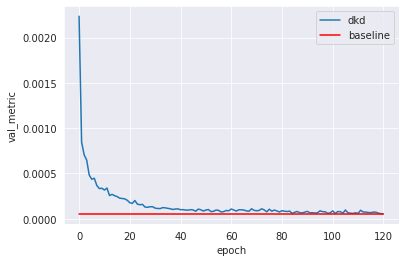

In [6]:
sns.lineplot(x=list(range(len(final_history))), y=final_history, label='dkd')
plt.xlabel('epoch')
sns.lineplot(x=list(range(len(final_history))), y=[VERY_IMPORTANT_CONSTANT]*len(final_history), label='baseline', color='red')
plt.ylabel('val_metric')